https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/

In [1]:
!nvidia-smi

Tue Jun  6 17:23:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from keras import Model
from keras.models import Sequential
from keras.layers import Conv2D, LeakyReLU, Flatten, Dropout, Dense, Reshape, Conv2DTranspose, Input, Embedding, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras.utils import plot_model
from keras.datasets.fashion_mnist import load_data
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
# load the images into memory
(X_train,y_train),(X_test,y_test) = load_data()

# summarize the shape of the dataset
print('X_train',X_train.shape)
print('y_train',y_train.shape)
print('X_test',X_test.shape)
print('y_test',y_test.shape)

4422102/4422102 [==============================] - 0s 0us/step
X_train (60000, 28, 28)
y_train (60000,)
X_test (10000, 28, 28)
y_test (10000,)


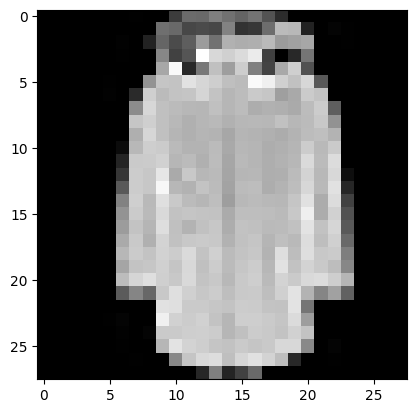

In [4]:
# plot raw pixel data
idx = random.choice(range(X_train.shape[0]))
plt.imshow(X_train[idx],cmap='gray')

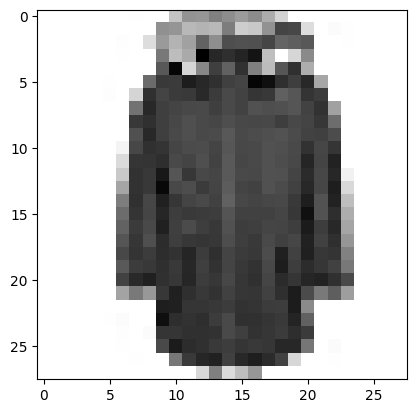

In [5]:
# plot raw pixel data
plt.imshow(X_train[idx],cmap='gray_r')

In [6]:
# create and save a plot of generated images (reversed grayscale)
def show_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i], cmap='gray_r')
    plt.show()

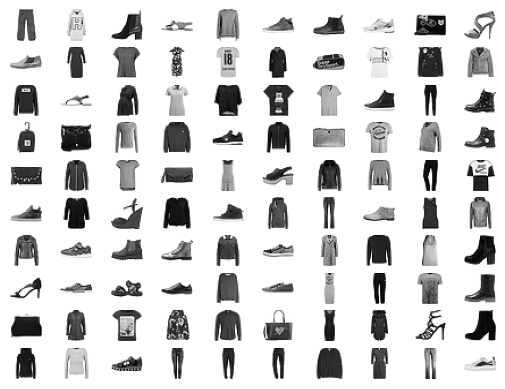

In [7]:
idx = random.choice(range(X_train.shape[0]-100))
X = X_train[idx:idx+100]

show_plot(X,10)

In [91]:
def define_discriminator(in_shape=(28,28,1), n_classes=10):
  # label input
  in_label = Input(shape=(1,))
  # embedding for categorical input
  li = Embedding(n_classes, 50)(in_label)
  # scale up to image dimensions with linear activation
  n_nodes = in_shape[0] * in_shape[1]
  li = Dense(n_nodes)(li)
  # reshape to additional channel
  li = Reshape((in_shape[0], in_shape[1], 1))(li)
  # image input
  in_image = Input(shape=in_shape)
  # concat label as a channel
  merge = Concatenate()([in_image, li])
  # downsample
  fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
  fe = LeakyReLU(alpha=0.2)(fe)
  # downsample
  fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  # flatten feature maps
  fe = Flatten()(fe)
  # dropout
  fe = Dropout(0.4)(fe)
  # output
  out_layer = Dense(1, activation='sigmoid')(fe)
  # define model
  model = Model([in_image, in_label], out_layer)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

Model: "model_39"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_53 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_26 (Embedding)       (None, 1, 50)        500         ['input_53[0][0]']               
                                                                                                  
 dense_52 (Dense)               (None, 1, 784)       39984       ['embedding_26[0][0]']           
                                                                                                  
 input_54 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                           

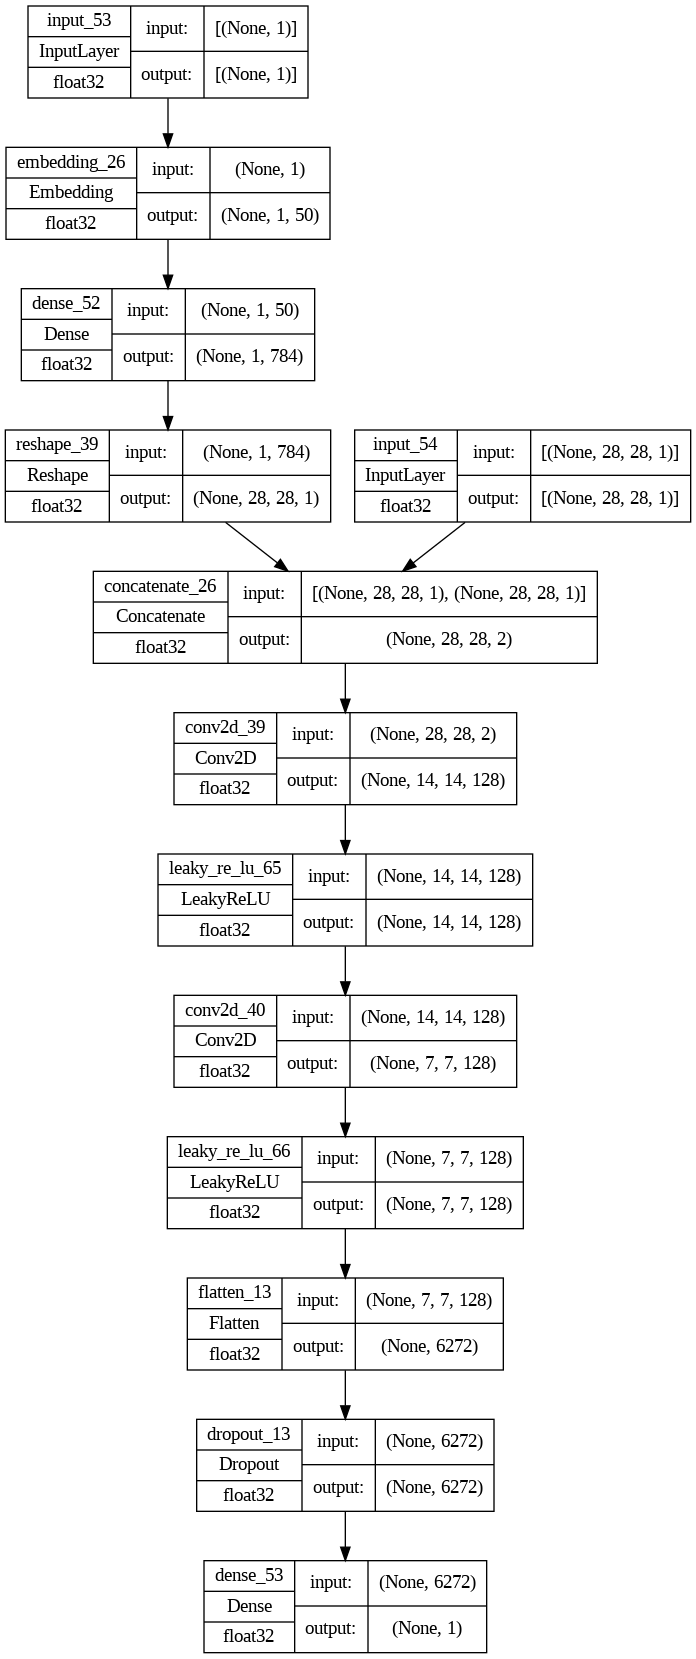

In [92]:
discriminator = define_discriminator(in_shape=(28,28,1),n_classes=10)
discriminator.summary()
plot_model(discriminator,to_file='discriminator.png',show_shapes=True,show_dtype=True)

In [93]:
# define the standalone generator model
def define_generator(latent_dim,n_classes=10):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes,50)(in_label)
    # linear multiplication
    n_nodes= 7*7
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((7,7,1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes=128*7*7
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7,7,128))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen,li])
    # upsample to 14x14
    gen = Conv2DTranspose(128,(4,4),strides=(2,2),padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(128,(4,4),strides=(2,2),padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # output
    out_layer = Conv2D(1,(7,7),activation='tanh',padding='same')(gen)
    # define model
    model = Model([in_lat,in_label],out_layer)
    return model

Model: "model_40"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_56 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_55 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 dense_55 (Dense)               (None, 6272)         633472      ['input_56[0][0]']               
                                                                                                  
 embedding_27 (Embedding)       (None, 1, 50)        500         ['input_55[0][0]']               
                                                                                           

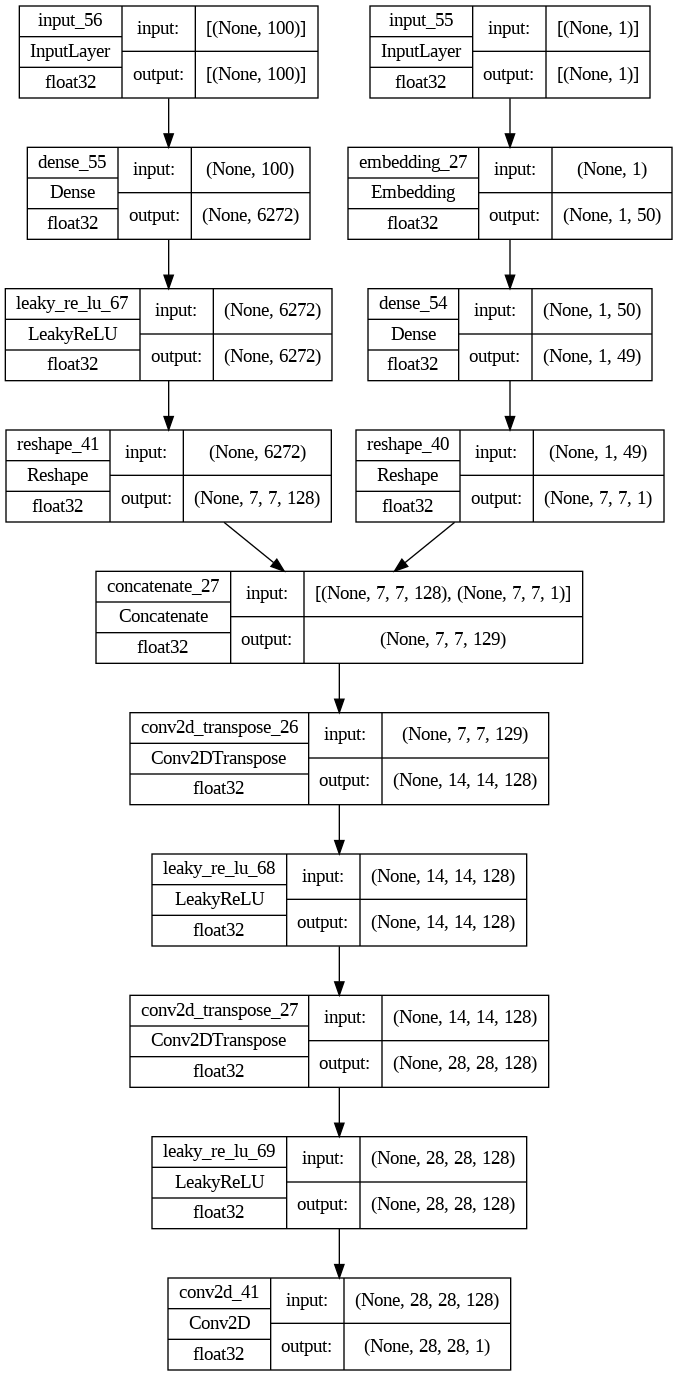

In [94]:
latent_dim=100
generator = define_generator(latent_dim,n_classes=10)
generator.summary()
plot_model(generator,to_file='generator.png',show_shapes=True,show_dtype=True)

In [95]:
# define the combined generator and discrimator model, for updating the generator
def define_gan(g_model,d_model):
    # make weights in the discriminator not trainable
    d_model.trainable=False
    # get noise and label inputs from generator model
    gen_noise,gen_label=g_model.input
    # get image output from generator model
    gen_output = g_model.output
    # connect image output and label from generator as inputs to discriminator
    gan_output = d_model([gen_output,gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise,gen_label],gan_output)
    # compile model
    opt = Adam(learning_rate=0.0002,beta_1=0.5)
    model.compile(loss='binary_crossentropy',optimizer=opt)
    return model

Model: "model_41"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_56 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_55 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 dense_55 (Dense)               (None, 6272)         633472      ['input_56[0][0]']               
                                                                                                  
 embedding_27 (Embedding)       (None, 1, 50)        500         ['input_55[0][0]']               
                                                                                           

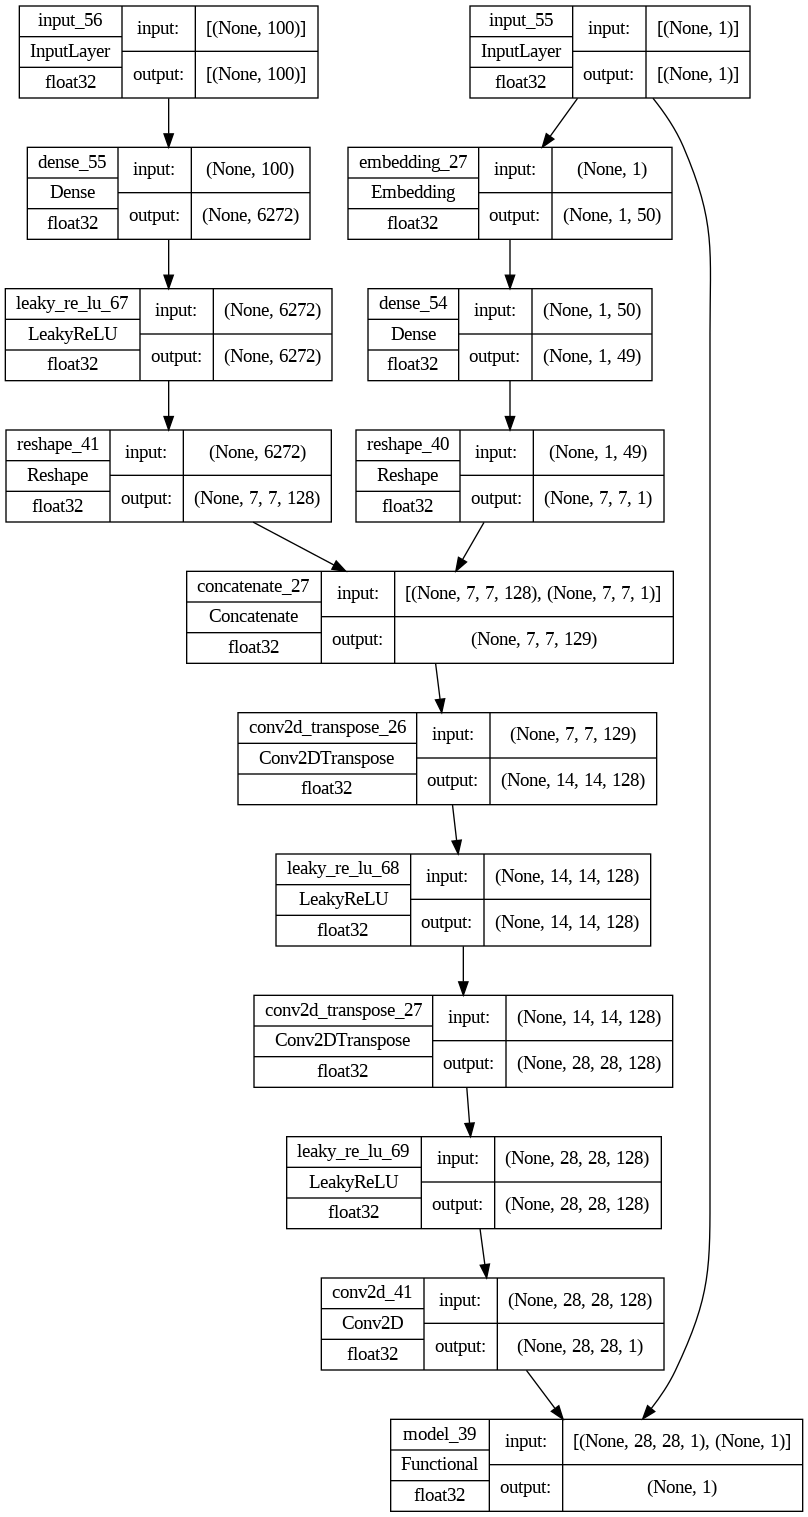

In [96]:
gan_model = define_gan(generator,discriminator)
gan_model.summary()
plot_model(gan_model,to_file='cgan.png',show_shapes=True,show_dtype=True)

In [97]:
# load fashion mnist images
def load_real_samples():
    #load dataset
    (trainX,trainy),(_,_) = load_data()
    # expand to 3d e.g add channels
    X = np.expand_dims(trainX,axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X-127.5)/127.5
    return [X,trainy]

In [98]:
# select real samples
def generate_real_samples(dataset,n_samples):
    # split into images and labels
    images,labels = dataset
    # choose radnom instances
    ix = np.random.randint(0,images.shape[0],n_samples)
    # select images and labels
    X, labels = images[ix],labels[ix]
    # generate class labels
    y = np.ones((n_samples,1))
    return [X,labels],y

In [99]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim,n_samples,n_classes=10):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim*n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples,latent_dim)
    # generate labels
    labels = np.random.randint(0,n_classes,n_samples)
    return [z_input,labels]

In [100]:
# use the generator to generate n fake examples with class labels
def generate_fake_samples(generator,latent_dim,n_samples):
    # generate points in latent space
    z_input,labels_input=generate_latent_points(latent_dim,n_samples)
    # predict outputs
    images = generator.predict([z_input,labels_input])
    # create class labels
    y = np.zeros((n_samples,1))
    return [images,labels_input],y

In [101]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
  bat_per_epo = int(dataset[0].shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
      # update discriminator model weights
      d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
      # generate 'fake' examples
      [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # update discriminator model weights
      d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
      # prepare points in latent space as input for the generator
      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = np.ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
      (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    # save the generator model
    g_model.save('cgan_generator.h5')

In [106]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()

4/4 [==============================] - 0s 6ms/step


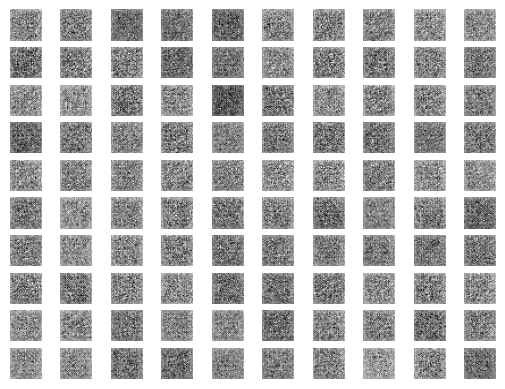

In [108]:
# genarate
latent_points,labels = generate_latent_points(100,100)
# specify labels
labels = np.asarray([x for _ in range(10) for x in range(10)])
# generate images
X = g_model.predict([latent_points,labels])
# scale from [-1:1] or [0:1]
X = (X + 1)/2.0
# plot the result
show_plot(X, 10)

In [109]:
# train model
train(g_model,d_model,gan_model,dataset,latent_dim,n_epochs=30,n_batch=128)

2/2 [==============================] - 0s 6ms/step
>1, 1/468, d1=0.708, d2=0.704 g=0.688
2/2 [==============================] - 0s 7ms/step
>1, 2/468, d1=0.410, d2=0.708 g=0.690
2/2 [==============================] - 0s 10ms/step
>1, 3/468, d1=0.188, d2=0.700 g=0.715
2/2 [==============================] - 0s 7ms/step
>1, 4/468, d1=0.067, d2=0.668 g=0.751
2/2 [==============================] - 0s 6ms/step
>1, 5/468, d1=0.024, d2=0.660 g=0.765
2/2 [==============================] - 0s 6ms/step
>1, 6/468, d1=0.025, d2=0.713 g=0.748
2/2 [==============================] - 0s 7ms/step
>1, 7/468, d1=0.017, d2=0.791 g=0.726
2/2 [==============================] - 0s 7ms/step
>1, 8/468, d1=0.019, d2=0.779 g=0.780
2/2 [==============================] - 0s 6ms/step
>1, 9/468, d1=0.043, d2=0.643 g=0.967
2/2 [==============================] - 0s 6ms/step
>1, 10/468, d1=0.078, d2=0.475 g=1.258
2/2 [==============================] - 0s 7ms/step
>1, 11/468, d1=0.065, d2=0.345 g=1.570
2/2 [=============

>1, 468/468, d1=0.002, d2=0.001 g=8.920
2/2 [==============================] - 0s 6ms/step
>2, 1/468, d1=0.000, d2=0.000 g=9.146
2/2 [==============================] - 0s 7ms/step
>2, 2/468, d1=0.003, d2=0.000 g=8.609
2/2 [==============================] - 0s 7ms/step
>2, 3/468, d1=0.000, d2=0.001 g=8.692
2/2 [==============================] - 0s 7ms/step
>2, 4/468, d1=0.024, d2=0.005 g=6.459
2/2 [==============================] - 0s 7ms/step
>2, 5/468, d1=0.000, d2=0.011 g=8.373
2/2 [==============================] - 0s 7ms/step
>2, 6/468, d1=0.000, d2=0.001 g=9.649
2/2 [==============================] - 0s 7ms/step
>2, 7/468, d1=0.000, d2=0.000 g=10.285
2/2 [==============================] - 0s 6ms/step
>2, 8/468, d1=0.000, d2=0.000 g=10.308
2/2 [==============================] - 0s 7ms/step
>2, 9/468, d1=0.001, d2=0.000 g=10.263
2/2 [==============================] - 0s 7ms/step
>2, 10/468, d1=0.000, d2=0.000 g=9.890
2/2 [==============================] - 0s 7ms/step
>2, 11/468, d1=

>2, 468/468, d1=0.000, d2=0.000 g=10.716
2/2 [==============================] - 0s 8ms/step
>3, 1/468, d1=0.000, d2=0.000 g=10.695
2/2 [==============================] - 0s 8ms/step
>3, 2/468, d1=0.000, d2=0.000 g=11.138
2/2 [==============================] - 0s 10ms/step
>3, 3/468, d1=0.000, d2=0.000 g=10.777
2/2 [==============================] - 0s 7ms/step
>3, 4/468, d1=0.000, d2=0.000 g=11.001
2/2 [==============================] - 0s 7ms/step
>3, 5/468, d1=0.000, d2=0.000 g=10.928
2/2 [==============================] - 0s 8ms/step
>3, 6/468, d1=0.000, d2=0.000 g=10.973
2/2 [==============================] - 0s 7ms/step
>3, 7/468, d1=0.000, d2=0.000 g=10.769
2/2 [==============================] - 0s 8ms/step
>3, 8/468, d1=0.000, d2=0.000 g=10.666
2/2 [==============================] - 0s 7ms/step
>3, 9/468, d1=0.000, d2=0.000 g=10.903
2/2 [==============================] - 0s 8ms/step
>3, 10/468, d1=0.000, d2=0.000 g=11.194
2/2 [==============================] - 0s 8ms/step
>3, 11

>3, 468/468, d1=0.015, d2=4.668 g=187.228
2/2 [==============================] - 0s 8ms/step
>4, 1/468, d1=21.654, d2=0.000 g=41.463
2/2 [==============================] - 0s 8ms/step
>4, 2/468, d1=1.883, d2=0.000 g=1.564
2/2 [==============================] - 0s 8ms/step
>4, 3/468, d1=0.000, d2=4.272 g=47.289
2/2 [==============================] - 0s 8ms/step
>4, 4/468, d1=1.315, d2=0.000 g=69.795
2/2 [==============================] - 0s 8ms/step
>4, 5/468, d1=2.014, d2=0.000 g=57.957
2/2 [==============================] - 0s 8ms/step
>4, 6/468, d1=0.704, d2=0.000 g=48.749
2/2 [==============================] - 0s 8ms/step
>4, 7/468, d1=0.368, d2=0.000 g=41.605
2/2 [==============================] - 0s 8ms/step
>4, 8/468, d1=0.866, d2=0.000 g=30.028
2/2 [==============================] - 0s 8ms/step
>4, 9/468, d1=0.418, d2=0.000 g=16.283
2/2 [==============================] - 0s 8ms/step
>4, 10/468, d1=0.108, d2=0.000 g=10.069
2/2 [==============================] - 0s 8ms/step
>4, 11

>4, 468/468, d1=0.000, d2=0.001 g=9.340
2/2 [==============================] - 0s 11ms/step
>5, 1/468, d1=0.000, d2=0.000 g=9.619
2/2 [==============================] - 0s 9ms/step
>5, 2/468, d1=0.000, d2=0.001 g=9.742
2/2 [==============================] - 0s 7ms/step
>5, 3/468, d1=0.000, d2=0.000 g=9.735
2/2 [==============================] - 0s 9ms/step
>5, 4/468, d1=0.000, d2=0.000 g=10.148
2/2 [==============================] - 0s 9ms/step
>5, 5/468, d1=0.000, d2=0.000 g=9.770
2/2 [==============================] - 0s 7ms/step
>5, 6/468, d1=0.000, d2=0.000 g=10.104
2/2 [==============================] - 0s 8ms/step
>5, 7/468, d1=0.039, d2=0.001 g=7.522
2/2 [==============================] - 0s 9ms/step
>5, 8/468, d1=0.000, d2=0.004 g=7.237
2/2 [==============================] - 0s 8ms/step
>5, 9/468, d1=0.000, d2=0.002 g=8.185
2/2 [==============================] - 0s 7ms/step
>5, 10/468, d1=0.000, d2=0.002 g=8.791
2/2 [==============================] - 0s 9ms/step
>5, 11/468, d1=

>5, 468/468, d1=0.000, d2=0.000 g=11.302
2/2 [==============================] - 0s 10ms/step
>6, 1/468, d1=0.000, d2=0.000 g=11.523
2/2 [==============================] - 0s 8ms/step
>6, 2/468, d1=0.000, d2=0.000 g=11.373
2/2 [==============================] - 0s 7ms/step
>6, 3/468, d1=0.000, d2=0.000 g=11.789
2/2 [==============================] - 0s 7ms/step
>6, 4/468, d1=0.000, d2=0.000 g=11.468
2/2 [==============================] - 0s 9ms/step
>6, 5/468, d1=0.000, d2=0.000 g=11.654
2/2 [==============================] - 0s 7ms/step
>6, 6/468, d1=0.000, d2=0.000 g=11.516
2/2 [==============================] - 0s 6ms/step
>6, 7/468, d1=0.000, d2=0.000 g=11.335
2/2 [==============================] - 0s 8ms/step
>6, 8/468, d1=0.000, d2=0.000 g=11.105
2/2 [==============================] - 0s 7ms/step
>6, 9/468, d1=0.000, d2=0.000 g=10.961
2/2 [==============================] - 0s 8ms/step
>6, 10/468, d1=0.000, d2=0.000 g=11.362
2/2 [==============================] - 0s 7ms/step
>6, 11

>6, 468/468, d1=0.001, d2=0.000 g=11.741
2/2 [==============================] - 0s 7ms/step
>7, 1/468, d1=0.000, d2=0.000 g=11.149
2/2 [==============================] - 0s 9ms/step
>7, 2/468, d1=0.006, d2=0.000 g=9.801
2/2 [==============================] - 0s 7ms/step
>7, 3/468, d1=0.000, d2=0.000 g=9.952
2/2 [==============================] - 0s 7ms/step
>7, 4/468, d1=0.000, d2=0.000 g=9.711
2/2 [==============================] - 0s 6ms/step
>7, 5/468, d1=0.000, d2=0.000 g=10.348
2/2 [==============================] - 0s 11ms/step
>7, 6/468, d1=0.000, d2=0.000 g=10.305
2/2 [==============================] - 0s 11ms/step
>7, 7/468, d1=0.000, d2=0.000 g=10.311
2/2 [==============================] - 0s 11ms/step
>7, 8/468, d1=0.000, d2=0.000 g=10.338
2/2 [==============================] - 0s 10ms/step
>7, 9/468, d1=0.000, d2=0.000 g=10.147
2/2 [==============================] - 0s 10ms/step
>7, 10/468, d1=0.000, d2=0.000 g=10.627
2/2 [==============================] - 0s 9ms/step
>7, 1

>7, 468/468, d1=0.000, d2=0.000 g=11.457
2/2 [==============================] - 0s 9ms/step
>8, 1/468, d1=0.000, d2=0.000 g=11.454
2/2 [==============================] - 0s 16ms/step
>8, 2/468, d1=0.000, d2=0.000 g=11.990
2/2 [==============================] - 0s 12ms/step
>8, 3/468, d1=0.000, d2=0.000 g=11.483
2/2 [==============================] - 0s 8ms/step
>8, 4/468, d1=0.000, d2=0.000 g=11.474
2/2 [==============================] - 0s 12ms/step
>8, 5/468, d1=0.000, d2=0.000 g=11.775
2/2 [==============================] - 0s 6ms/step
>8, 6/468, d1=0.000, d2=0.000 g=11.506
2/2 [==============================] - 0s 7ms/step
>8, 7/468, d1=0.000, d2=0.000 g=11.725
2/2 [==============================] - 0s 7ms/step
>8, 8/468, d1=0.000, d2=0.000 g=11.839
2/2 [==============================] - 0s 9ms/step
>8, 9/468, d1=0.000, d2=0.000 g=11.639
2/2 [==============================] - 0s 8ms/step
>8, 10/468, d1=0.000, d2=0.000 g=11.610
2/2 [==============================] - 0s 8ms/step
>8, 

>8, 468/468, d1=0.215, d2=0.256 g=2.710
2/2 [==============================] - 0s 11ms/step
>9, 1/468, d1=0.481, d2=0.313 g=2.104
2/2 [==============================] - 0s 10ms/step
>9, 2/468, d1=0.267, d2=0.415 g=2.356
2/2 [==============================] - 0s 10ms/step
>9, 3/468, d1=0.343, d2=0.240 g=2.751
2/2 [==============================] - 0s 11ms/step
>9, 4/468, d1=0.502, d2=0.594 g=2.388
2/2 [==============================] - 0s 8ms/step
>9, 5/468, d1=0.460, d2=0.524 g=2.386
2/2 [==============================] - 0s 7ms/step
>9, 6/468, d1=0.655, d2=0.646 g=1.954
2/2 [==============================] - 0s 8ms/step
>9, 7/468, d1=0.395, d2=0.524 g=1.991
2/2 [==============================] - 0s 8ms/step
>9, 8/468, d1=0.396, d2=0.355 g=2.109
2/2 [==============================] - 0s 11ms/step
>9, 9/468, d1=0.352, d2=0.470 g=2.298
2/2 [==============================] - 0s 11ms/step
>9, 10/468, d1=0.516, d2=0.379 g=2.373
2/2 [==============================] - 0s 10ms/step
>9, 11/468,

>9, 468/468, d1=0.344, d2=0.237 g=2.277
2/2 [==============================] - 0s 8ms/step
>10, 1/468, d1=0.368, d2=0.510 g=2.819
2/2 [==============================] - 0s 8ms/step
>10, 2/468, d1=0.451, d2=0.268 g=2.628
2/2 [==============================] - 0s 14ms/step
>10, 3/468, d1=0.543, d2=0.468 g=2.424
2/2 [==============================] - 0s 6ms/step
>10, 4/468, d1=0.349, d2=0.291 g=2.344
2/2 [==============================] - 0s 6ms/step
>10, 5/468, d1=0.345, d2=0.255 g=2.564
2/2 [==============================] - 0s 7ms/step
>10, 6/468, d1=0.425, d2=0.358 g=2.514
2/2 [==============================] - 0s 11ms/step
>10, 7/468, d1=0.319, d2=0.312 g=2.553
2/2 [==============================] - 0s 8ms/step
>10, 8/468, d1=0.518, d2=0.330 g=2.133
2/2 [==============================] - 0s 7ms/step
>10, 9/468, d1=0.391, d2=0.335 g=1.949
2/2 [==============================] - 0s 6ms/step
>10, 10/468, d1=0.250, d2=0.238 g=2.104
2/2 [==============================] - 0s 7ms/step
>10, 1

>10, 468/468, d1=0.398, d2=0.299 g=2.365
2/2 [==============================] - 0s 11ms/step
>11, 1/468, d1=0.552, d2=0.254 g=1.933
2/2 [==============================] - 0s 9ms/step
>11, 2/468, d1=0.288, d2=0.451 g=2.247
2/2 [==============================] - 0s 7ms/step
>11, 3/468, d1=0.360, d2=0.481 g=2.585
2/2 [==============================] - 0s 11ms/step
>11, 4/468, d1=0.471, d2=0.199 g=2.599
2/2 [==============================] - 0s 6ms/step
>11, 5/468, d1=0.490, d2=0.280 g=1.889
2/2 [==============================] - 0s 11ms/step
>11, 6/468, d1=0.353, d2=0.465 g=1.984
2/2 [==============================] - 0s 10ms/step
>11, 7/468, d1=0.516, d2=0.473 g=2.015
2/2 [==============================] - 0s 14ms/step
>11, 8/468, d1=0.427, d2=0.358 g=2.222
2/2 [==============================] - 0s 12ms/step
>11, 9/468, d1=0.383, d2=0.341 g=2.325
2/2 [==============================] - 0s 12ms/step
>11, 10/468, d1=0.499, d2=0.333 g=2.015
2/2 [==============================] - 0s 12ms/step

>11, 468/468, d1=0.661, d2=0.466 g=1.914
2/2 [==============================] - 0s 11ms/step
>12, 1/468, d1=0.409, d2=0.349 g=2.188
2/2 [==============================] - 0s 12ms/step
>12, 2/468, d1=0.338, d2=0.402 g=2.198
2/2 [==============================] - 0s 14ms/step
>12, 3/468, d1=0.474, d2=0.220 g=2.209
2/2 [==============================] - 0s 12ms/step
>12, 4/468, d1=0.321, d2=0.333 g=2.137
2/2 [==============================] - 0s 7ms/step
>12, 5/468, d1=0.320, d2=0.305 g=2.046
2/2 [==============================] - 0s 10ms/step
>12, 6/468, d1=0.432, d2=0.490 g=2.329
2/2 [==============================] - 0s 11ms/step
>12, 7/468, d1=0.400, d2=0.315 g=2.184
2/2 [==============================] - 0s 6ms/step
>12, 8/468, d1=0.554, d2=0.373 g=2.032
2/2 [==============================] - 0s 12ms/step
>12, 9/468, d1=0.478, d2=0.478 g=2.006
2/2 [==============================] - 0s 11ms/step
>12, 10/468, d1=0.274, d2=0.438 g=2.127
2/2 [==============================] - 0s 12ms/ste

>12, 468/468, d1=0.383, d2=0.340 g=2.066
2/2 [==============================] - 0s 14ms/step
>13, 1/468, d1=0.603, d2=0.383 g=2.179
2/2 [==============================] - 0s 13ms/step
>13, 2/468, d1=0.424, d2=0.388 g=2.068
2/2 [==============================] - 0s 12ms/step
>13, 3/468, d1=0.422, d2=0.515 g=1.853
2/2 [==============================] - 0s 11ms/step
>13, 4/468, d1=0.371, d2=0.466 g=2.094
2/2 [==============================] - 0s 14ms/step
>13, 5/468, d1=0.587, d2=0.413 g=2.249
2/2 [==============================] - 0s 13ms/step
>13, 6/468, d1=0.479, d2=0.371 g=2.112
2/2 [==============================] - 0s 7ms/step
>13, 7/468, d1=0.400, d2=0.416 g=2.156
2/2 [==============================] - 0s 7ms/step
>13, 8/468, d1=0.536, d2=0.511 g=2.004
2/2 [==============================] - 0s 8ms/step
>13, 9/468, d1=0.375, d2=0.368 g=2.084
2/2 [==============================] - 0s 6ms/step
>13, 10/468, d1=0.447, d2=0.281 g=1.972
2/2 [==============================] - 0s 7ms/step
>

>13, 468/468, d1=0.477, d2=0.307 g=2.213
2/2 [==============================] - 0s 10ms/step
>14, 1/468, d1=0.531, d2=0.519 g=1.873
2/2 [==============================] - 0s 13ms/step
>14, 2/468, d1=0.415, d2=0.394 g=2.199
2/2 [==============================] - 0s 8ms/step
>14, 3/468, d1=0.514, d2=0.505 g=1.877
2/2 [==============================] - 0s 10ms/step
>14, 4/468, d1=0.360, d2=0.463 g=2.125
2/2 [==============================] - 0s 9ms/step
>14, 5/468, d1=0.407, d2=0.379 g=2.148
2/2 [==============================] - 0s 14ms/step
>14, 6/468, d1=0.431, d2=0.512 g=2.448
2/2 [==============================] - 0s 8ms/step
>14, 7/468, d1=0.657, d2=0.370 g=2.000
2/2 [==============================] - 0s 7ms/step
>14, 8/468, d1=0.467, d2=0.360 g=1.927
2/2 [==============================] - 0s 6ms/step
>14, 9/468, d1=0.413, d2=0.517 g=2.145
2/2 [==============================] - 0s 12ms/step
>14, 10/468, d1=0.477, d2=0.431 g=1.889
2/2 [==============================] - 0s 7ms/step
>1

>14, 468/468, d1=0.447, d2=0.389 g=2.182
2/2 [==============================] - 0s 14ms/step
>15, 1/468, d1=0.623, d2=0.411 g=1.775
2/2 [==============================] - 0s 13ms/step
>15, 2/468, d1=0.420, d2=0.466 g=2.122
2/2 [==============================] - 0s 12ms/step
>15, 3/468, d1=0.365, d2=0.472 g=1.899
2/2 [==============================] - 0s 7ms/step
>15, 4/468, d1=0.496, d2=0.442 g=2.214
2/2 [==============================] - 0s 6ms/step
>15, 5/468, d1=0.695, d2=0.429 g=1.842
2/2 [==============================] - 0s 6ms/step
>15, 6/468, d1=0.441, d2=0.424 g=1.838
2/2 [==============================] - 0s 13ms/step
>15, 7/468, d1=0.462, d2=0.403 g=1.828
2/2 [==============================] - 0s 5ms/step
>15, 8/468, d1=0.538, d2=0.348 g=2.014
2/2 [==============================] - 0s 10ms/step
>15, 9/468, d1=0.451, d2=0.488 g=1.857
2/2 [==============================] - 0s 13ms/step
>15, 10/468, d1=0.573, d2=0.361 g=1.913
2/2 [==============================] - 0s 10ms/step


>15, 468/468, d1=0.630, d2=0.470 g=1.671
2/2 [==============================] - 0s 8ms/step
>16, 1/468, d1=0.717, d2=0.449 g=1.578
2/2 [==============================] - 0s 9ms/step
>16, 2/468, d1=0.425, d2=0.589 g=1.780
2/2 [==============================] - 0s 10ms/step
>16, 3/468, d1=0.530, d2=0.407 g=1.921
2/2 [==============================] - 0s 10ms/step
>16, 4/468, d1=0.559, d2=0.487 g=1.634
2/2 [==============================] - 0s 7ms/step
>16, 5/468, d1=0.397, d2=0.411 g=1.802
2/2 [==============================] - 0s 11ms/step
>16, 6/468, d1=0.397, d2=0.408 g=1.671
2/2 [==============================] - 0s 14ms/step
>16, 7/468, d1=0.548, d2=0.435 g=1.812
2/2 [==============================] - 0s 8ms/step
>16, 8/468, d1=0.430, d2=0.399 g=1.805
2/2 [==============================] - 0s 7ms/step
>16, 9/468, d1=0.527, d2=0.463 g=1.951
2/2 [==============================] - 0s 10ms/step
>16, 10/468, d1=0.445, d2=0.384 g=2.085
2/2 [==============================] - 0s 10ms/step
>

>16, 468/468, d1=0.482, d2=0.491 g=1.866
2/2 [==============================] - 0s 13ms/step
>17, 1/468, d1=0.402, d2=0.464 g=1.870
2/2 [==============================] - 0s 6ms/step
>17, 2/468, d1=0.484, d2=0.394 g=2.086
2/2 [==============================] - 0s 17ms/step
>17, 3/468, d1=0.596, d2=0.467 g=1.745
2/2 [==============================] - 0s 9ms/step
>17, 4/468, d1=0.504, d2=0.547 g=1.952
2/2 [==============================] - 0s 15ms/step
>17, 5/468, d1=0.530, d2=0.343 g=1.855
2/2 [==============================] - 0s 7ms/step
>17, 6/468, d1=0.694, d2=0.504 g=1.702
2/2 [==============================] - 0s 6ms/step
>17, 7/468, d1=0.515, d2=0.572 g=1.552
2/2 [==============================] - 0s 10ms/step
>17, 8/468, d1=0.412, d2=0.486 g=1.627
2/2 [==============================] - 0s 7ms/step
>17, 9/468, d1=0.512, d2=0.581 g=1.760
2/2 [==============================] - 0s 10ms/step
>17, 10/468, d1=0.560, d2=0.502 g=1.857
2/2 [==============================] - 0s 9ms/step
>1

>17, 468/468, d1=0.430, d2=0.517 g=1.841
2/2 [==============================] - 0s 12ms/step
>18, 1/468, d1=0.449, d2=0.432 g=1.717
2/2 [==============================] - 0s 7ms/step
>18, 2/468, d1=0.535, d2=0.446 g=1.768
2/2 [==============================] - 0s 7ms/step
>18, 3/468, d1=0.422, d2=0.399 g=1.827
2/2 [==============================] - 0s 13ms/step
>18, 4/468, d1=0.416, d2=0.533 g=1.715
2/2 [==============================] - 0s 17ms/step
>18, 5/468, d1=0.660, d2=0.538 g=1.711
2/2 [==============================] - 0s 6ms/step
>18, 6/468, d1=0.575, d2=0.488 g=1.819
2/2 [==============================] - 0s 15ms/step
>18, 7/468, d1=0.716, d2=0.415 g=1.652
2/2 [==============================] - 0s 8ms/step
>18, 8/468, d1=0.594, d2=0.580 g=1.439
2/2 [==============================] - 0s 6ms/step
>18, 9/468, d1=0.497, d2=0.539 g=1.528
2/2 [==============================] - 0s 6ms/step
>18, 10/468, d1=0.525, d2=0.565 g=1.754
2/2 [==============================] - 0s 6ms/step
>18

>18, 468/468, d1=0.468, d2=0.643 g=1.718
2/2 [==============================] - 0s 14ms/step
>19, 1/468, d1=0.548, d2=0.340 g=1.729
2/2 [==============================] - 0s 13ms/step
>19, 2/468, d1=0.589, d2=0.487 g=1.656
2/2 [==============================] - 0s 10ms/step
>19, 3/468, d1=0.544, d2=0.374 g=1.695
2/2 [==============================] - 0s 6ms/step
>19, 4/468, d1=0.587, d2=0.595 g=1.548
2/2 [==============================] - 0s 13ms/step
>19, 5/468, d1=0.459, d2=0.489 g=1.956
2/2 [==============================] - 0s 6ms/step
>19, 6/468, d1=0.532, d2=0.495 g=1.682
2/2 [==============================] - 0s 8ms/step
>19, 7/468, d1=0.582, d2=0.493 g=1.731
2/2 [==============================] - 0s 10ms/step
>19, 8/468, d1=0.737, d2=0.472 g=1.667
2/2 [==============================] - 0s 19ms/step
>19, 9/468, d1=0.484, d2=0.514 g=1.619
2/2 [==============================] - 0s 12ms/step
>19, 10/468, d1=0.483, d2=0.528 g=1.563
2/2 [==============================] - 0s 13ms/step

>19, 468/468, d1=0.572, d2=0.549 g=1.613
2/2 [==============================] - 0s 16ms/step
>20, 1/468, d1=0.475, d2=0.499 g=1.685
2/2 [==============================] - 0s 8ms/step
>20, 2/468, d1=0.486, d2=0.439 g=1.981
2/2 [==============================] - 0s 8ms/step
>20, 3/468, d1=0.527, d2=0.432 g=1.472
2/2 [==============================] - 0s 8ms/step
>20, 4/468, d1=0.506, d2=0.418 g=1.812
2/2 [==============================] - 0s 10ms/step
>20, 5/468, d1=0.631, d2=0.566 g=1.511
2/2 [==============================] - 0s 8ms/step
>20, 6/468, d1=0.476, d2=0.471 g=1.526
2/2 [==============================] - 0s 6ms/step
>20, 7/468, d1=0.390, d2=0.551 g=1.717
2/2 [==============================] - 0s 16ms/step
>20, 8/468, d1=0.670, d2=0.420 g=1.847
2/2 [==============================] - 0s 6ms/step
>20, 9/468, d1=0.551, d2=0.579 g=1.700
2/2 [==============================] - 0s 7ms/step
>20, 10/468, d1=0.467, d2=0.497 g=1.819
2/2 [==============================] - 0s 7ms/step
>20,

>20, 468/468, d1=0.425, d2=0.375 g=1.630
2/2 [==============================] - 0s 7ms/step
>21, 1/468, d1=0.434, d2=0.387 g=1.602
2/2 [==============================] - 0s 11ms/step
>21, 2/468, d1=0.647, d2=0.454 g=1.483
2/2 [==============================] - 0s 12ms/step
>21, 3/468, d1=0.495, d2=0.536 g=1.562
2/2 [==============================] - 0s 6ms/step
>21, 4/468, d1=0.487, d2=0.613 g=1.743
2/2 [==============================] - 0s 7ms/step
>21, 5/468, d1=0.668, d2=0.456 g=1.635
2/2 [==============================] - 0s 12ms/step
>21, 6/468, d1=0.586, d2=0.572 g=1.533
2/2 [==============================] - 0s 6ms/step
>21, 7/468, d1=0.474, d2=0.403 g=1.641
2/2 [==============================] - 0s 9ms/step
>21, 8/468, d1=0.548, d2=0.583 g=1.410
2/2 [==============================] - 0s 11ms/step
>21, 9/468, d1=0.494, d2=0.512 g=1.673
2/2 [==============================] - 0s 9ms/step
>21, 10/468, d1=0.458, d2=0.557 g=1.699
2/2 [==============================] - 0s 6ms/step
>21

>21, 468/468, d1=0.485, d2=0.762 g=1.651
2/2 [==============================] - 0s 6ms/step
>22, 1/468, d1=0.573, d2=0.422 g=1.667
2/2 [==============================] - 0s 13ms/step
>22, 2/468, d1=0.510, d2=0.501 g=1.635
2/2 [==============================] - 0s 15ms/step
>22, 3/468, d1=0.625, d2=0.440 g=1.577
2/2 [==============================] - 0s 5ms/step
>22, 4/468, d1=0.534, d2=0.577 g=1.510
2/2 [==============================] - 0s 14ms/step
>22, 5/468, d1=0.419, d2=0.523 g=1.618
2/2 [==============================] - 0s 6ms/step
>22, 6/468, d1=0.606, d2=0.537 g=1.655
2/2 [==============================] - 0s 7ms/step
>22, 7/468, d1=0.578, d2=0.526 g=1.563
2/2 [==============================] - 0s 6ms/step
>22, 8/468, d1=0.577, d2=0.495 g=1.658
2/2 [==============================] - 0s 15ms/step
>22, 9/468, d1=0.701, d2=0.423 g=1.593
2/2 [==============================] - 0s 13ms/step
>22, 10/468, d1=0.461, d2=0.545 g=1.534
2/2 [==============================] - 0s 7ms/step
>2

>22, 468/468, d1=0.682, d2=0.543 g=1.562
2/2 [==============================] - 0s 8ms/step
>23, 1/468, d1=0.416, d2=0.465 g=1.477
2/2 [==============================] - 0s 7ms/step
>23, 2/468, d1=0.628, d2=0.487 g=1.501
2/2 [==============================] - 0s 10ms/step
>23, 3/468, d1=0.489, d2=0.571 g=1.535
2/2 [==============================] - 0s 12ms/step
>23, 4/468, d1=0.626, d2=0.441 g=1.597
2/2 [==============================] - 0s 12ms/step
>23, 5/468, d1=0.534, d2=0.613 g=1.489
2/2 [==============================] - 0s 11ms/step
>23, 6/468, d1=0.516, d2=0.535 g=1.618
2/2 [==============================] - 0s 14ms/step
>23, 7/468, d1=0.726, d2=0.503 g=1.640
2/2 [==============================] - 0s 6ms/step
>23, 8/468, d1=0.562, d2=0.469 g=1.613
2/2 [==============================] - 0s 10ms/step
>23, 9/468, d1=0.444, d2=0.555 g=1.516
2/2 [==============================] - 0s 9ms/step
>23, 10/468, d1=0.636, d2=0.606 g=1.564
2/2 [==============================] - 0s 6ms/step
>

>23, 468/468, d1=0.627, d2=0.569 g=1.542
2/2 [==============================] - 0s 8ms/step
>24, 1/468, d1=0.628, d2=0.560 g=1.551
2/2 [==============================] - 0s 7ms/step
>24, 2/468, d1=0.572, d2=0.528 g=1.569
2/2 [==============================] - 0s 11ms/step
>24, 3/468, d1=0.516, d2=0.507 g=1.570
2/2 [==============================] - 0s 7ms/step
>24, 4/468, d1=0.481, d2=0.581 g=1.428
2/2 [==============================] - 0s 7ms/step
>24, 5/468, d1=0.557, d2=0.514 g=1.612
2/2 [==============================] - 0s 13ms/step
>24, 6/468, d1=0.507, d2=0.539 g=1.600
2/2 [==============================] - 0s 13ms/step
>24, 7/468, d1=0.652, d2=0.470 g=1.464
2/2 [==============================] - 0s 6ms/step
>24, 8/468, d1=0.571, d2=0.432 g=1.651
2/2 [==============================] - 0s 6ms/step
>24, 9/468, d1=0.553, d2=0.495 g=1.412
2/2 [==============================] - 0s 12ms/step
>24, 10/468, d1=0.430, d2=0.495 g=1.529
2/2 [==============================] - 0s 8ms/step
>24

>24, 468/468, d1=0.620, d2=0.599 g=1.496
2/2 [==============================] - 0s 15ms/step
>25, 1/468, d1=0.540, d2=0.448 g=1.614
2/2 [==============================] - 0s 8ms/step
>25, 2/468, d1=0.641, d2=0.544 g=1.577
2/2 [==============================] - 0s 6ms/step
>25, 3/468, d1=0.609, d2=0.458 g=1.455
2/2 [==============================] - 0s 12ms/step
>25, 4/468, d1=0.579, d2=0.590 g=1.394
2/2 [==============================] - 0s 14ms/step
>25, 5/468, d1=0.492, d2=0.539 g=1.368
2/2 [==============================] - 0s 5ms/step
>25, 6/468, d1=0.614, d2=0.506 g=1.428
2/2 [==============================] - 0s 10ms/step
>25, 7/468, d1=0.734, d2=0.583 g=1.500
2/2 [==============================] - 0s 6ms/step
>25, 8/468, d1=0.567, d2=0.592 g=1.518
2/2 [==============================] - 0s 13ms/step
>25, 9/468, d1=0.557, d2=0.521 g=1.599
2/2 [==============================] - 0s 13ms/step
>25, 10/468, d1=0.561, d2=0.556 g=1.509
2/2 [==============================] - 0s 12ms/step


>25, 468/468, d1=0.561, d2=0.548 g=1.605
2/2 [==============================] - 0s 10ms/step
>26, 1/468, d1=0.654, d2=0.507 g=1.503
2/2 [==============================] - 0s 8ms/step
>26, 2/468, d1=0.528, d2=0.474 g=1.531
2/2 [==============================] - 0s 6ms/step
>26, 3/468, d1=0.590, d2=0.465 g=1.481
2/2 [==============================] - 0s 8ms/step
>26, 4/468, d1=0.492, d2=0.575 g=1.382
2/2 [==============================] - 0s 6ms/step
>26, 5/468, d1=0.587, d2=0.561 g=1.577
2/2 [==============================] - 0s 10ms/step
>26, 6/468, d1=0.585, d2=0.517 g=1.633
2/2 [==============================] - 0s 9ms/step
>26, 7/468, d1=0.499, d2=0.465 g=1.561
2/2 [==============================] - 0s 8ms/step
>26, 8/468, d1=0.536, d2=0.484 g=1.576
2/2 [==============================] - 0s 6ms/step
>26, 9/468, d1=0.606, d2=0.536 g=1.513
2/2 [==============================] - 0s 6ms/step
>26, 10/468, d1=0.469, d2=0.551 g=1.542
2/2 [==============================] - 0s 10ms/step
>26,

>26, 468/468, d1=0.383, d2=0.651 g=1.501
2/2 [==============================] - 0s 7ms/step
>27, 1/468, d1=0.535, d2=0.423 g=1.477
2/2 [==============================] - 0s 6ms/step
>27, 2/468, d1=0.556, d2=0.486 g=1.538
2/2 [==============================] - 0s 16ms/step
>27, 3/468, d1=0.546, d2=0.484 g=1.481
2/2 [==============================] - 0s 9ms/step
>27, 4/468, d1=0.501, d2=0.560 g=1.556
2/2 [==============================] - 0s 14ms/step
>27, 5/468, d1=0.596, d2=0.457 g=1.471
2/2 [==============================] - 0s 12ms/step
>27, 6/468, d1=0.579, d2=0.482 g=1.555
2/2 [==============================] - 0s 12ms/step
>27, 7/468, d1=0.515, d2=0.443 g=1.330
2/2 [==============================] - 0s 8ms/step
>27, 8/468, d1=0.616, d2=0.622 g=1.433
2/2 [==============================] - 0s 14ms/step
>27, 9/468, d1=0.646, d2=0.548 g=1.415
2/2 [==============================] - 0s 10ms/step
>27, 10/468, d1=0.347, d2=0.494 g=1.494
2/2 [==============================] - 0s 7ms/step
>

>27, 468/468, d1=0.546, d2=0.682 g=1.480
2/2 [==============================] - 0s 12ms/step
>28, 1/468, d1=0.719, d2=0.651 g=1.522
2/2 [==============================] - 0s 14ms/step
>28, 2/468, d1=0.547, d2=0.497 g=1.548
2/2 [==============================] - 0s 15ms/step
>28, 3/468, d1=0.676, d2=0.551 g=1.449
2/2 [==============================] - 0s 15ms/step
>28, 4/468, d1=0.611, d2=0.449 g=1.489
2/2 [==============================] - 0s 14ms/step
>28, 5/468, d1=0.619, d2=0.557 g=1.346
2/2 [==============================] - 0s 15ms/step
>28, 6/468, d1=0.578, d2=0.652 g=1.259
2/2 [==============================] - 0s 7ms/step
>28, 7/468, d1=0.553, d2=0.557 g=1.428
2/2 [==============================] - 0s 12ms/step
>28, 8/468, d1=0.503, d2=0.439 g=1.375
2/2 [==============================] - 0s 13ms/step
>28, 9/468, d1=0.628, d2=0.526 g=1.410
2/2 [==============================] - 0s 7ms/step
>28, 10/468, d1=0.617, d2=0.532 g=1.390
2/2 [==============================] - 0s 9ms/step

>28, 468/468, d1=0.581, d2=0.505 g=1.479
2/2 [==============================] - 0s 7ms/step
>29, 1/468, d1=0.806, d2=0.595 g=1.384
2/2 [==============================] - 0s 16ms/step
>29, 2/468, d1=0.510, d2=0.593 g=1.331
2/2 [==============================] - 0s 7ms/step
>29, 3/468, d1=0.559, d2=0.479 g=1.387
2/2 [==============================] - 0s 6ms/step
>29, 4/468, d1=0.644, d2=0.537 g=1.312
2/2 [==============================] - 0s 8ms/step
>29, 5/468, d1=0.524, d2=0.444 g=1.395
2/2 [==============================] - 0s 9ms/step
>29, 6/468, d1=0.507, d2=0.513 g=1.447
2/2 [==============================] - 0s 12ms/step
>29, 7/468, d1=0.505, d2=0.554 g=1.495
2/2 [==============================] - 0s 12ms/step
>29, 8/468, d1=0.576, d2=0.603 g=1.526
2/2 [==============================] - 0s 11ms/step
>29, 9/468, d1=0.710, d2=0.533 g=1.592
2/2 [==============================] - 0s 9ms/step
>29, 10/468, d1=0.624, d2=0.508 g=1.339
2/2 [==============================] - 0s 15ms/step
>2

>29, 468/468, d1=0.732, d2=0.515 g=1.492
2/2 [==============================] - 0s 6ms/step
>30, 1/468, d1=0.624, d2=0.662 g=1.431
2/2 [==============================] - 0s 7ms/step
>30, 2/468, d1=0.665, d2=0.479 g=1.413
2/2 [==============================] - 0s 6ms/step
>30, 3/468, d1=0.529, d2=0.507 g=1.310
2/2 [==============================] - 0s 12ms/step
>30, 4/468, d1=0.453, d2=0.735 g=1.391
2/2 [==============================] - 0s 11ms/step
>30, 5/468, d1=0.660, d2=0.453 g=1.724
2/2 [==============================] - 0s 6ms/step
>30, 6/468, d1=0.728, d2=0.522 g=1.423
2/2 [==============================] - 0s 11ms/step
>30, 7/468, d1=0.624, d2=0.615 g=1.294
2/2 [==============================] - 0s 16ms/step
>30, 8/468, d1=0.631, d2=0.527 g=1.439
2/2 [==============================] - 0s 6ms/step
>30, 9/468, d1=0.524, d2=0.488 g=1.468
2/2 [==============================] - 0s 7ms/step
>30, 10/468, d1=0.536, d2=0.663 g=1.451
2/2 [==============================] - 0s 9ms/step
>30

>30, 468/468, d1=0.485, d2=0.507 g=1.396


4/4 [==============================] - 0s 6ms/step


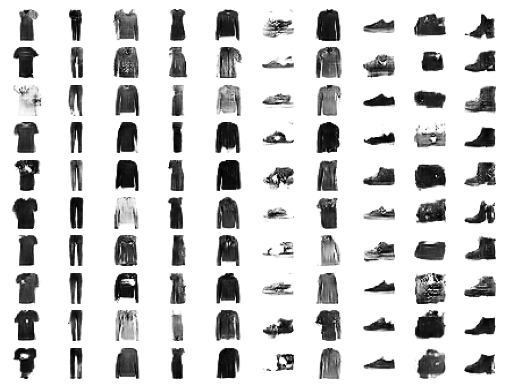

In [111]:
# load model
loaded_model = load_model('cgan_generator.h5')

# genarate
latent_points,labels = generate_latent_points(100,100)
# specify labels
labels = np.asarray([x for _ in range(10) for x in range(10)])
# generate images
X = loaded_model.predict([latent_points,labels])
# scale from [-1:1] or [0:1]
X = (X + 1)/2.0
# plot the result
show_plot(X, 10)